## Study of TUC policy for a simple network

In [1]:
import numpy as np
import copy
import math
import scipy.linalg as la
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### INITIALIZING NETWORK

def init():

    # Setting size of the network
    j = 2 # number of junctions
    z = 3 # number of links per junction
    i = 2 # number of inflowing links per junction, has to be smaller than z
    o = 1 # number of outflow links

    # Setting time frame of the network
    C = np.full((j),120) # cycle time
    L = np.full((j),20) # lost time
    T = 5 # control cycle

    # Turning rates
    Tu0 = np.ones(j) * 0.3 # turners who leave the system

    Tu = np.ones((j,i,o))
    Tu[1,0] = 0.5 # t_AB QUantity of cars that go from link A to link B

    # Saturation flows
    S = np.full((j,z),40) # Saturation flow for each incoming link
    S[0,0]=30 # S_w1 incoming street
    S[0,1]=40 # S_w2 lateral streets smaller
    S[1,1]=40 # S_w3 lateral streets smaller
    
    return (Tu0,Tu,C,S,L,T,j,o)


def compute_X_G(Tu0,Tu,C,S,L,T,j,o,time_var=True):

    # System matrices
    A1 = np.zeros(j) # initialise one A1 for each junction
    A2 = np.zeros(j) # initialise one A2 for each junction
    A3 = np.zeros(j) # initialise one A3 for each junction
    
    
    # Defininf links and junction interactions 
    for junction in range(j):
        A1[junction] = (1-Tu0[junction]) * (Tu[junction,0,0] * S[junction,0] / C[junction])
        A2[junction] = (1-Tu0[junction]) * (Tu[junction,1,0] * S[junction,1] / C[junction])
        A3[junction] = - (S[junction,2] / C[junction])

   
    # Riccati matrices
    A = np.identity(j)
    B = np.array([[A1[0], A2[0], A3[0]  ,0     ,  0    ],
                  [0    , 0    , A1[1]  ,A2[1] ,  A3[1]]])
    Q = np.identity(2)/100
    R = np.identity(5)*1e-4

    # Solving Riccati equations

    aux = la.solve_discrete_are(A,B,Q,R) # Solving Riccati equations
    L_ric = -la.inv(R + B.T.dot(aux).dot(B)) @ B.T.dot(aux).dot(A) # Finding L

    # Definin feasible green times boundaries
    bounds = ((15,85),(15,85),(15,85),(15,85),(70,90)) if time_var else ((50,50),(50,50),(50,50),(50,50),(70,70))

    # Constraint to make sure that all signals in a link stay within the cycle defined time.
    linear_constraint = ({'type': 'eq', 'fun': lambda x:  x[0] + x[1] + L[0] - C[0]}, # Link 1
                         {'type': 'eq', 'fun': lambda x: x[2] + x[3] + L[1] - C[1]}) # Link 2
                         #{'type': 'eq', 'fun': lambda x: x[4] - 65}) # Exit link
    
    # Initializing green times and number of cars per link
    G = np.full((1,5),50)
    X = np.full((1,2),0)
    
    # Defining perturbation
    k = np.linspace(0,100,num=100)
    perturbations = 25*np.sin(6.25 * k/100)
    perturbations[perturbations < 0] = 0
    
    # Minimization problem to find feasible gs as close as possible to the optimal gs found by riccati eq
    for k in range(100):

        _ = A @ X[-1] + (B @ G[-1,:]) + perturbations[k]
        _[_<0] = 0
        _[_>100] = 100

        X = np.vstack((X,_))
        G = np.vstack((G,G[-1:,]-L_ric @ (X[-1]-X[-2])))
        
        g = G[-1]

        min_f = minimize(greens, # function to be minimized
                         x0=g, # init point
                         args = g,
                         method='SLSQP', # Sequential Least SQuares Profact_gramminfact_g method for minimizinfact_g
                         jac = greens_grad, # fact_gradient of the function
                         hess = hess, # Hessian
                         constraints = linear_constraint, # Linear constraints
                         bounds = bounds) # Bounds

        G[-1] = min_f.x
    
    return (X,G,perturbations)

# Function to be minimized f
def greens(fact_g,*g):
    return (np.sum((g-fact_g)**2))

# fact_gradient of f
def greens_grad(fact_g,*g):
    return (-2*(g-fact_g))

# Hessian of f
def hess(fact_g):
    return (np.identity(5)*2)


def make_plots(X,G,params,perturbations):
    
    k = np.linspace(0,100,num=100)
    colors_links = [sns.xkcd_rgb["dark yellow"],sns.xkcd_rgb["sea blue"],sns.xkcd_rgb["scarlet"]]
    colors_lights = [sns.xkcd_rgb["sand"],sns.xkcd_rgb["pale yellow"],sns.xkcd_rgb["sky"],sns.xkcd_rgb["ocean blue"],sns.xkcd_rgb["salmon pink"]]
    
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize = (10,4))
    axes[0].set_prop_cycle('color',colors_links)
    axes[0].plot(k,X[:-1,:])
    axes[0].plot(k,perturbations)
    axes[0].set_xlabel("periods",fontsize=12)
    axes[0].set_ylabel("Number of cars in the link",fontsize=12)
    axes[0].legend(["Link A","Link B","Perturbation"],loc=1)
    
    
    axes[1].set_prop_cycle('color',colors_lights)
    axes[1].plot(k,G[:-1,:])
    axes[1].set_xlabel("periods",fontsize=12)
    axes[1].set_ylabel("Green times",fontsize=12)
    axes[1].legend(["$G_{M1}$","$G_{M2}$","$G_{N1}$","$G_{N2}$","$G_{0}$"],loc=1)
    
    fig.suptitle(f"t_AB={params[0]}   S_in={params[1]}    t_out ={params[2]}",fontsize = 15)
    fig.savefig(f"t_AB={params[0]}   S_out={params[1]}    t_out ={params[2]}",bbox_inches='tight',format="png")
    
def make_plots2(X1,X2,params,perturbations):
    
    k = np.linspace(0,100,num=100)
    colors_links = [sns.xkcd_rgb["dark yellow"],sns.xkcd_rgb["sea blue"],sns.xkcd_rgb["scarlet"]]
    colors_lights = [sns.xkcd_rgb["sand"],sns.xkcd_rgb["pale yellow"],sns.xkcd_rgb["sky"],sns.xkcd_rgb["ocean blue"],sns.xkcd_rgb["salmon pink"]]
    
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize = (10,4))
    axes[0].set_prop_cycle('color',colors_links)
    axes[0].plot(k,X1[:-1,:])
    axes[0].plot(k,perturbations)
    axes[0].set_xlabel("periods",fontsize=12)
    axes[0].set_ylabel("Number of cars in the link",fontsize=12)
    axes[0].set_title("Variable r.o.w time")
    axes[0].legend(["Link A","Link B","Perturbation"],loc=1)
    
    axes[1].set_prop_cycle('color',colors_links)
    axes[1].plot(k,X2[:-1,:])
    axes[1].plot(k,perturbations)
    axes[1].set_xlabel("periods",fontsize=12)
    axes[1].set_ylabel("Number of cars in the link",fontsize=12)
    axes[1].set_title("Fixed r.o.w time")
    axes[1].legend(["Link A","Link B","Perturbation"],loc=1)
    
    #fig.suptitle(f"t_AB={params[0]}   S_in={params[1]}    t_out ={params[2]}",fontsize = 15)
    fig.savefig(f"t_AB={params[0]}-S_out={params[1]}-t_out ={params[2]}_var_not_var",bbox_inches='tight',format="png")

/home/jrd/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method SLSQP does not use Hessian information (hess).
  RuntimeWarning)


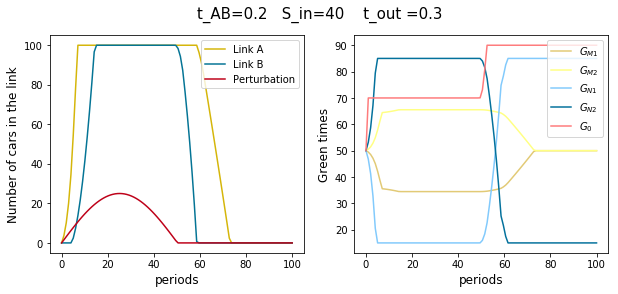

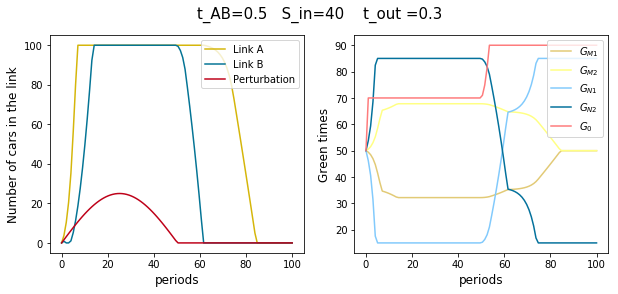

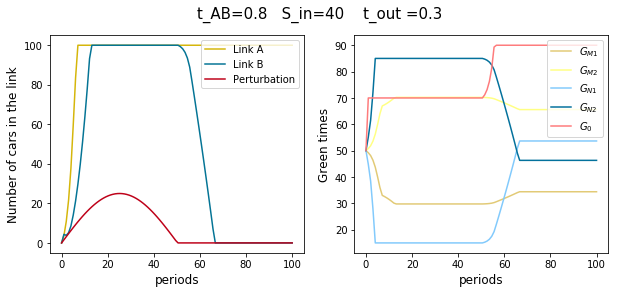

In [3]:
# Modifying turnig rates AB
Tu0,Tu,C,S,L,T,j,o = init()

params =[0.2,0.5,0.8]
for param in params:
    
    Tu[1,0] = param

    X,G,perturbations = compute_X_G(Tu0,Tu,C,S,L,T,j,o)
    make_plots(X,G,[Tu[1,0][0],S[0,1],Tu0[0]],perturbations);

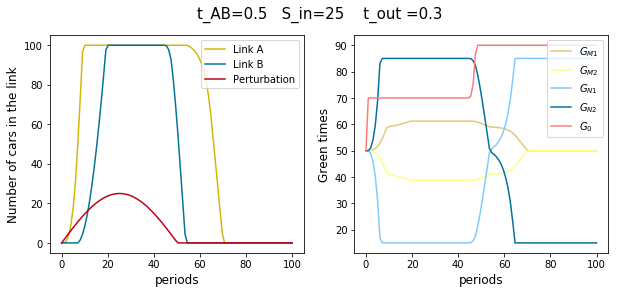

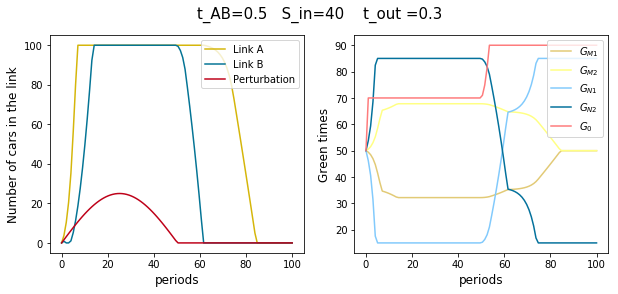

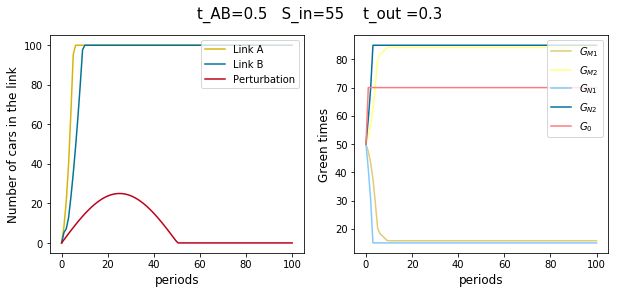

In [4]:
# Modifying lateral streets saturation coef
Tu0,Tu,C,S,L,T,j,o = init()

params =[25,40,55]
for param in params:
    
    S[0,1]=param # S_w2 lateral streets smaller
    S[1,1]=param # S_w3 lateral streets smaller = param

    X,G,perturbations = compute_X_G(Tu0,Tu,C,S,L,T,j,o)
    make_plots(X,G,[Tu[1,0][0],S[0,1],Tu0[0]],perturbations);

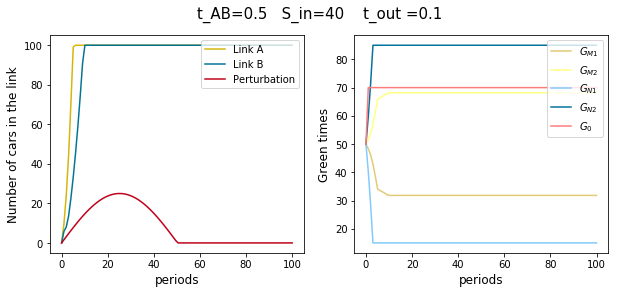

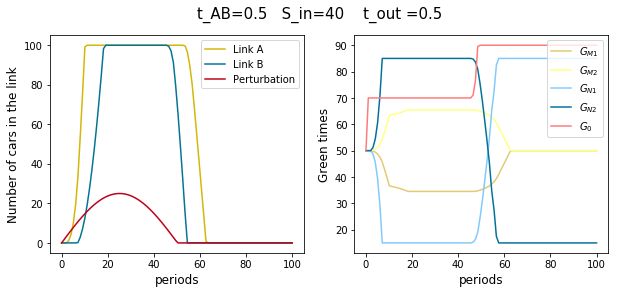

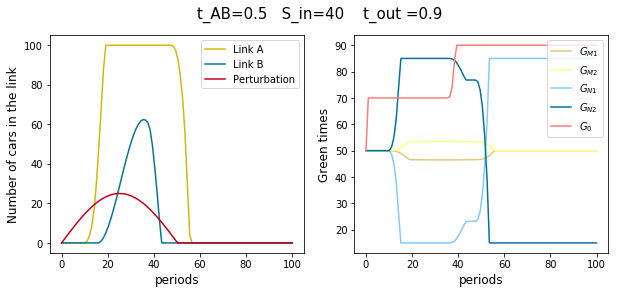

In [5]:
# Modifying exit rate
Tu0,Tu,C,S,L,T,j,o = init()

params =[0.1,0.5,0.9]
for param in params:
    
    Tu0= np.ones(len(Tu0)) * param #  Exit rate

    X,G,perturbations = compute_X_G(Tu0,Tu,C,S,L,T,j,o)
    make_plots(X,G,[Tu[1,0][0],S[0,1],Tu0[0]],perturbations);

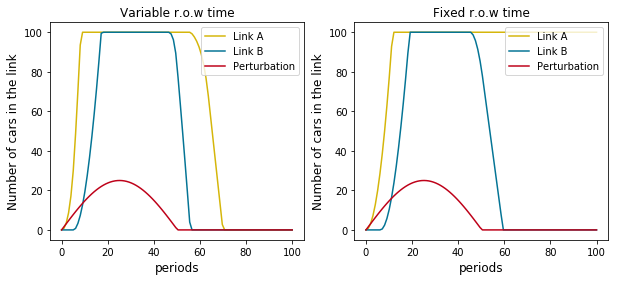

In [6]:
# Checking efficiency variable time r.o.w vs fixed r.o.w time

Tu0,Tu,C,S,L,T,j,o = init()

params =[30]
for param in params:
    
    S[0,1]=param # S_w2 lateral streets smaller
    S[1,1]=param # S_w3 lateral streets smaller = param
    
    X1,G1,perturbations = compute_X_G(Tu0,Tu,C,S,L,T,j,o)
    X2,G2,perturbations = compute_X_G(Tu0,Tu,C,S,L,T,j,o,time_var=False)
    make_plots2(X1,X2,[Tu[1,0][0],S[0,1],Tu0[0]],perturbations);